# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries

In [84]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from modules.reading import *
from modules.standardization import standardize_image
from modules.preprocessing import preproc_image
from modules.mask_and_contour import get_mask
from pandas import DataFrame

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

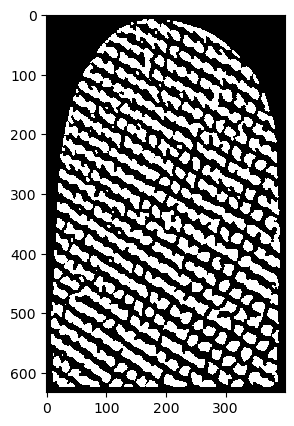

In [72]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)

plt.imshow(prep_im)
plt.show()

## Gradient of image

In [73]:
def get_gradient(image, rx=1, ry=1):

    dx = cv.Sobel(image, cv.CV_64F, rx, 0)
    dy = cv.Sobel(image, cv.CV_64F, 0, ry)
        
    return dx, dy

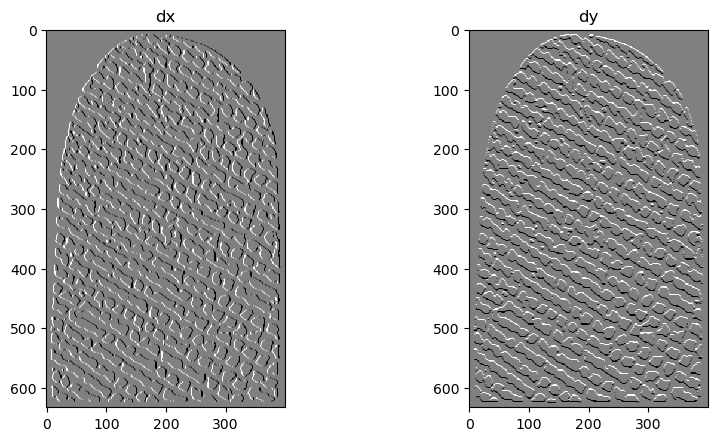

In [74]:
dx, dy = get_gradient(prep_im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(dx)
ax1.set_title('dx')

ax2.imshow(dy)
ax2.set_title("dy")

plt.show()

## Avarage gradient

In [75]:
def avg_grad(gx, gy, ksize, with_sqrt=True):
        
    gsq_real = np.square(gx) - np.square(gy)
    gsq_imag = 2*gx*gy

    gsq_avg_real = cv.GaussianBlur(gsq_real, (ksize,)*2, -1)
    gsq_avg_imag = cv.GaussianBlur(gsq_imag, (ksize,)*2, -1)

    if with_sqrt:
        g_avg = np.sqrt(gsq_avg_real + np.complex(0, 1)*gsq_avg_imag)
        
        real_part = g_avg.real
        complex_part = g_avg.imag
        return real_part, complex_part
    else:
        return gsq_avg_real, gsq_avg_imag

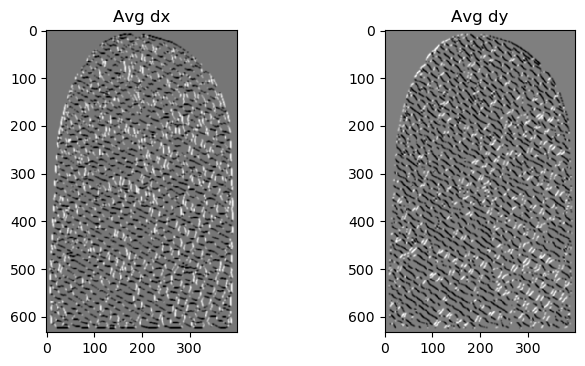

In [76]:
ksize=7

dx_avg, dy_avg = avg_grad(dx, dy, ksize, False)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(dx_avg, cmap=plt.cm.gray)
ax1.set_title("Avg dx")

ax2.imshow(dy_avg,cmap=plt.cm.gray)
ax2.set_title("Avg dy")

plt.show()

## Normalization of vectors

In [77]:
def norm_vector(dx, dy, eps=1e-3):
    
    lengths = np.sqrt(np.square(dx) + np.square(dy))
    norm_dx, norm_dy = np.divide(dx, np.add(lengths, eps)), np.divide(dy, np.add(lengths, eps))
    
    return norm_dx, norm_dy

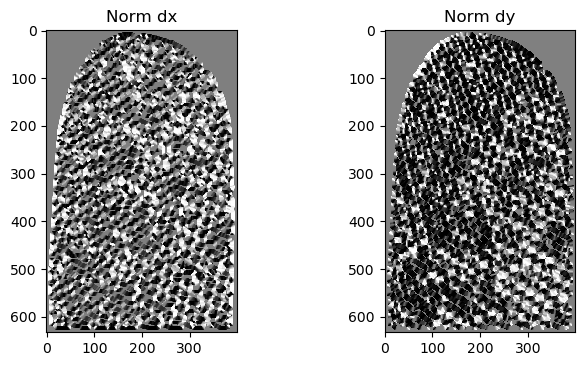

In [78]:
dx_norm, dy_norm = norm_vector(dx_avg, dy_avg)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(dx_norm, cmap=plt.cm.gray)
ax1.set_title("Norm dx")

ax2.imshow(dy_norm,cmap=plt.cm.gray)
ax2.set_title("Norm dy")
plt.show()

## Local scalar product

In [79]:
def scalar_product(dx, dy, ksize=7):
    
    part1 = cv.GaussianBlur(dx, (ksize, )*2, -1) * dx
    part2 = cv.GaussianBlur(dy, (ksize, )*2, -1) * dy
    
    sp = part1 + part2
    
    return sp

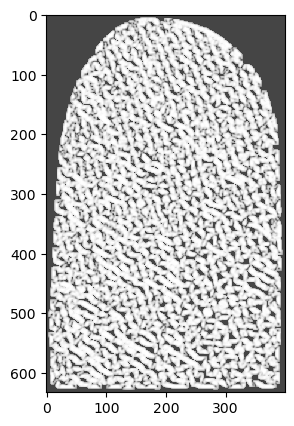

In [80]:
sp = scalar_product(dx_norm, dy_norm)

plt.imshow(sp, cmap=plt.cm.gray)
plt.show()

# Get mask

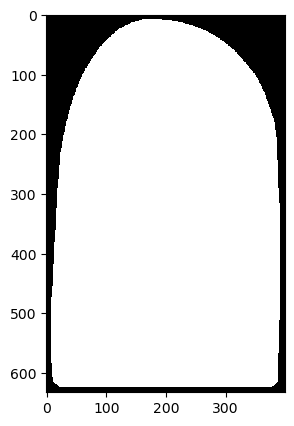

In [81]:
mask = get_mask(prep_im, with_ench=False) == 255

plt.imshow(mask)
plt.show()

## Scalar product histogram

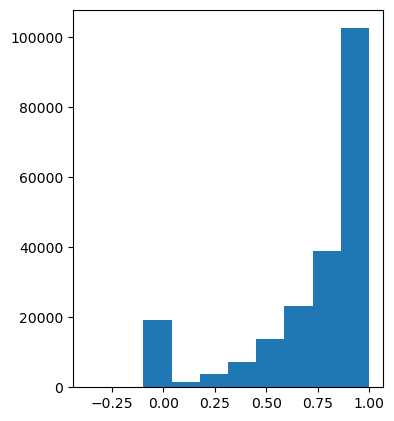

In [82]:
plt.hist(sp[mask])
plt.show()

## Function of getting scalar product  precentiles

In [113]:
def get_scalar_product_precentiles(im, ksize=13, percs=[0, 20, 40, 60]):
    
    dx, dy = get_gradient(im)
    dx_avg, dy_avg = avg_grad(dx, dy, ksize=ksize, with_sqrt=False)
    dx_norm, dy_norm = norm_vector(dx_avg, dy_avg)
    
    sp = scalar_product(dx_norm, dy_norm, ksize=ksize)
    mask = get_mask(im, with_ench=False) == 255
    
    percentiles = np.percentile(sp[mask], percs)
    
    return percentiles

In [114]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)

pepcentiles = get_scalar_product_precentiles(prep_im)


# Use Linear SVC for image classification

## Function for getting data

In [130]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = get_scalar_product_precentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [120]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_NOISE, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3
0,-0.742563,0.799692,0.939382,0.982928
1,-0.701168,0.894022,0.975744,0.990953
2,-0.706244,0.852309,0.963502,0.989765
3,-0.758531,0.847313,0.968539,0.991717
4,-0.666742,0.712823,0.894258,0.965105
...,...,...,...,...
90,-0.717872,0.515440,0.710598,0.828593
91,-0.654713,0.685828,0.861936,0.940670
92,-0.735558,0.612101,0.801560,0.903605
93,-0.623115,0.545853,0.734804,0.846535


## Train LinearSVC and get

Является хорошим, считается плохим [-0.72604119  0.67450181  0.85940765  0.94595816]


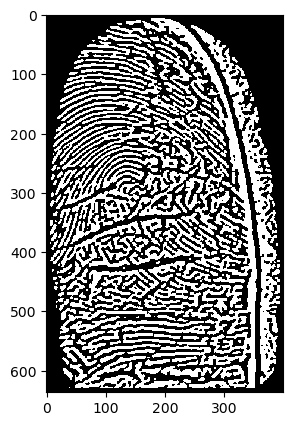

Является плохим, считается хорошим [-0.65471306  0.68582753  0.86193568  0.94066997]


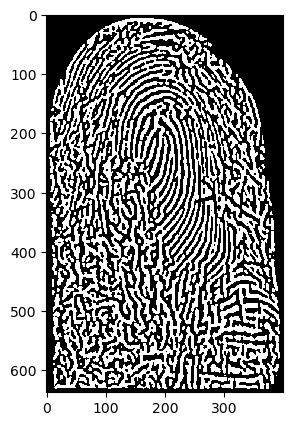

In [121]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=1000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()